## NLM Denoising Codec (OpenCV)  
Este cuaderno incluye:

a) Explicación teórica del algoritmo implementado.  
b) Implementación en un único archivo Python mediante `%%writefile`.  
c) Ejemplos de **compresión** y **descompresión**, y **test**.  
d) Composición del grupo.

## 1. Composición del grupo
- Adrián Jiménez Benítez
- Jesús Ortega Ayala


## 2. Explicación teórica (Non‑Local Means)

El **Non‑Local Means (NLM)** es un algoritmo de reducción de ruido que, en lugar de promediar solo vecinos inmediatos (filtros *locales* como gaussiano/mediana), **promedia píxeles cuya *vecindad* (parche) es similar**, aunque estén a cierta distancia dentro de una ventana de búsqueda.

Idea básica (por píxel):
1. Se toma un **parche** alrededor del píxel objetivo (p. ej. 7×7).
2. Se recorre una **ventana de búsqueda** alrededor (p. ej. 21×21) buscando parches parecidos.
3. Cada parche candidato aporta al resultado con un **peso** proporcional a la similitud (normalmente una distancia cuadrática entre parches, convertida a peso con una exponencial).
4. El nuevo valor del píxel es una **media ponderada** de los píxeles centrales de esos parches.

Parámetros típicos en OpenCV (implementación “fast”) según la documentación:
- **h**: fuerza del filtrado. Más alto ⇒ elimina más ruido, pero suaviza detalles.
- **hForColorComponents** (*hColor*): equivalente a *h* para componentes de color (solo color).
- **templateWindowSize**: tamaño del parche (impar; recomendado 7).
- **searchWindowSize**: tamaño de la ventana de búsqueda (impar; recomendado 21).
- Para secuencias: **temporalWindowSize** (impar): nº de frames vecinos usados.

Variantes usadas aquí:
- `cv.fastNlMeansDenoisingColored()` para **una** imagen en color.
- `cv.fastNlMeansDenoisingColoredMulti()` para **varios frames** (denoising temporal).

En este notebook se implementa un “codec” estilo VCF que:
- Genera ruido gaussiano sobre un frame.
- “Codifica” guardando el frame ruidoso.
- “Decodifica” aplicando NLM (OpenCV) y guardando el resultado.
- Evalúa PSNR antes/después del denoising.


## 3. Implementación (un solo archivo) usando `%%writefile`

La siguiente celda crea el archivo `NLM.py` con **toda la implementación** (codificador/decodificador + CLI).

In [13]:
%%writefile ../src/NLM.py
import os
import argparse
import numpy as np
import cv2 as cv
from skimage.metrics import peak_signal_noise_ratio as psnr

#   RUTAS BASE (VCF-like)
BASE_DIR    = "/tmp/NLM"
FRAMES_DIR  = os.path.join(BASE_DIR, "frames")
COMP_DIR    = os.path.join(BASE_DIR, "compressed")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

#   UTILIDADES
def ensure_dirs():
    os.makedirs(FRAMES_DIR, exist_ok=True)
    os.makedirs(COMP_DIR, exist_ok=True)
    os.makedirs(RESULTS_DIR, exist_ok=True)

def imread_bgr(path: str) -> np.ndarray:
    img = cv.imread(path, cv.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"No se pudo leer la imagen: {path}")
    return img

def imwrite_bgr(path: str, img: np.ndarray) -> None:
    os.makedirs(os.path.dirname(path), exist_ok=True)
    ok = cv.imwrite(path, img)
    if not ok:
        raise IOError(f"No se pudo guardar la imagen: {path}")

def add_gaussian_noise_u8(img_bgr_u8: np.ndarray, sigma: float = 25.0, seed: int = 123) -> np.ndarray:
    '''Ruido gaussiano aditivo N(0, sigma^2) en uint8.'''
    rng = np.random.default_rng(seed)
    noise = rng.normal(0.0, sigma, size=img_bgr_u8.shape).astype(np.float32)
    noisy = img_bgr_u8.astype(np.float32) + noise
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

#   NLM (OpenCV)
def nlm_color_single(img_bgr_u8: np.ndarray,
                     h: float = 10,
                     hColor: float = 10,
                     templateWindowSize: int = 7,
                     searchWindowSize: int = 21) -> np.ndarray:
    '''Denoising de una imagen en color usando OpenCV.'''
    return cv.fastNlMeansDenoisingColored(
        img_bgr_u8, None, h, hColor, templateWindowSize, searchWindowSize
    )

def nlm_color_multi(frames_bgr_u8: list,
                    imgToDenoiseIndex: int,
                    temporalWindowSize: int = 5,
                    h: float = 10,
                    hColor: float = 10,
                    templateWindowSize: int = 7,
                    searchWindowSize: int = 21) -> np.ndarray:
    '''Denoising temporal usando varios frames vecinos.'''
    return cv.fastNlMeansDenoisingColoredMulti(
        frames_bgr_u8, imgToDenoiseIndex, temporalWindowSize, None,
        h, hColor, templateWindowSize, searchWindowSize
    )

#   ENCODE / DECODE (VCF-like)
def encoder_main(frame_index: int = 20, noise_sigma: float = 25.0):
    '''"Encode": toma un frame, genera una versión ruidosa y la guarda en /compressed.'''
    ensure_dirs()
    files = sorted([f for f in os.listdir(FRAMES_DIR) if f.lower().endswith('.png')])

    if not files:
        raise RuntimeError(f"No hay frames en {FRAMES_DIR}. Genera /frames primero.")

    if frame_index >= len(files):
        raise RuntimeError(f"No existe el frame {frame_index}. Hay {len(files)} frames.")

    frame_name = files[frame_index]
    orig_path = os.path.join(FRAMES_DIR, frame_name)
    orig = imread_bgr(orig_path)

    noisy = add_gaussian_noise_u8(orig, sigma=noise_sigma)

    noisy_path = os.path.join(COMP_DIR, frame_name.replace('.png', '_noisy.png'))
    meta_path  = os.path.join(COMP_DIR, frame_name.replace('.png', '_meta.npz'))

    imwrite_bgr(noisy_path, noisy)
    np.savez(meta_path, frame_index=frame_index, noise_sigma=noise_sigma)

    print(f"[encode] original : {orig_path}")
    print(f"[encode] noisy    : {noisy_path}")
    print(f"[encode] meta     : {meta_path}")

def decoder_main(use_multi: bool = True, frame_index: int = 20,
                 temporalWindowSize: int = 5, h: float = 10, hColor: float = 10,
                 templateWindowSize: int = 7, searchWindowSize: int = 21):
    '''"Decode": carga el frame ruidoso y aplica NLM.'''
    ensure_dirs()

    noisy_candidates = sorted([f for f in os.listdir(COMP_DIR) if f.endswith('_noisy.png')])
    if not noisy_candidates:
        raise RuntimeError('No hay archivos _noisy.png en /compressed. Ejecuta encode primero.')

    noisy_file = None
    for f in noisy_candidates:
        if f.startswith(f'frame_{frame_index:03d}') or f'_{frame_index:03d}' in f:
            noisy_file = f
            break
    if noisy_file is None:
        noisy_file = noisy_candidates[0]

    noisy_path = os.path.join(COMP_DIR, noisy_file)
    noisy = imread_bgr(noisy_path)

    if use_multi:
        files = sorted([f for f in os.listdir(FRAMES_DIR) if f.lower().endswith('.png')])
        if len(files) < temporalWindowSize:
            raise RuntimeError(f'No hay suficientes frames para temporalWindowSize={temporalWindowSize}.')

        half = temporalWindowSize // 2
        start = max(0, frame_index - half)
        end = min(len(files), start + temporalWindowSize)
        start = max(0, end - temporalWindowSize)

        window_files = files[start:end]
        frames = [imread_bgr(os.path.join(FRAMES_DIR, fn)) for fn in window_files]

        local_index = frame_index - start
        if 0 <= local_index < len(frames):
            frames[local_index] = noisy

        den = nlm_color_multi(frames, imgToDenoiseIndex=local_index,
                              temporalWindowSize=len(frames),
                              h=h, hColor=hColor,
                              templateWindowSize=templateWindowSize,
                              searchWindowSize=searchWindowSize)
        tag = 'nlm_multi'
    else:
        den = nlm_color_single(noisy, h=h, hColor=hColor,
                               templateWindowSize=templateWindowSize,
                               searchWindowSize=searchWindowSize)
        tag = 'nlm_single'

    out_path = os.path.join(RESULTS_DIR, noisy_file.replace('_noisy.png', f'_{tag}.png'))
    imwrite_bgr(out_path, den)

    print(f"[decode] noisy    : {noisy_path}")
    print(f"[decode] denoised : {out_path}")

def test_main(frame_index: int = 20):
    '''Calcula PSNR antes/después del denoising.'''
    ensure_dirs()
    files = sorted([f for f in os.listdir(FRAMES_DIR) if f.lower().endswith('.png')])
    if not files:
        raise RuntimeError('No hay frames para testear.')

    orig_path = os.path.join(FRAMES_DIR, files[frame_index])
    orig = imread_bgr(orig_path)

    noisy_candidates = sorted([f for f in os.listdir(COMP_DIR) if f.endswith('_noisy.png')])
    if not noisy_candidates:
        raise RuntimeError('No hay noisy en /compressed. Ejecuta encode primero.')
    noisy_path = os.path.join(COMP_DIR, noisy_candidates[0])
    noisy = imread_bgr(noisy_path)

    den_candidates = sorted([f for f in os.listdir(RESULTS_DIR) if f.endswith('_nlm_multi.png')]) + \
                    sorted([f for f in os.listdir(RESULTS_DIR) if f.endswith('_nlm_single.png')])
    if not den_candidates:
        raise RuntimeError('No hay denoised en /results. Ejecuta decode primero.')
    den_path = os.path.join(RESULTS_DIR, den_candidates[0])
    den = imread_bgr(den_path)

    p_noisy = psnr(orig, noisy, data_range=255)
    p_den   = psnr(orig, den, data_range=255)

    print(f"[test] PSNR(original, noisy)    = {p_noisy:.2f} dB")
    print(f"[test] PSNR(original, denoised) = {p_den:.2f} dB")

def compare_main():
    ensure_dirs()
    print('FRAMES_DIR :', FRAMES_DIR)
    print('COMP_DIR   :', COMP_DIR)
    print('RESULTS_DIR:', RESULTS_DIR)

def main():
    parser = argparse.ArgumentParser(description='NLM codec (OpenCV) - VCF-like')
    sub = parser.add_subparsers(dest='command', required=True)

    p_enc = sub.add_parser('encode')
    p_enc.add_argument('--frame', type=int, default=20)
    p_enc.add_argument('--sigma', type=float, default=25.0)

    p_dec = sub.add_parser('decode')
    p_dec.add_argument('--frame', type=int, default=20)
    p_dec.add_argument('--multi', action='store_true', help='Usa fastNlMeansDenoisingColoredMulti()')
    p_dec.add_argument('--temporal', type=int, default=5)
    p_dec.add_argument('--h', type=float, default=10)
    p_dec.add_argument('--hColor', type=float, default=10)
    p_dec.add_argument('--template', type=int, default=7)
    p_dec.add_argument('--search', type=int, default=21)

    p_test = sub.add_parser('test')
    p_test.add_argument('--frame', type=int, default=20)

    sub.add_parser('compare')

    args = parser.parse_args()

    if args.command == 'encode':
        encoder_main(frame_index=args.frame, noise_sigma=args.sigma)
    elif args.command == 'decode':
        decoder_main(use_multi=args.multi, frame_index=args.frame,
                     temporalWindowSize=args.temporal, h=args.h, hColor=args.hColor,
                     templateWindowSize=args.template, searchWindowSize=args.search)
    elif args.command == 'test':
        test_main(frame_index=args.frame)
    elif args.command == 'compare':
        compare_main()

if __name__ == '__main__':
    main()

Overwriting ../src/NLM.py


In [14]:
import os, shutil

BASE_DIR = "/tmp/NLM"
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

os.makedirs(os.path.join(BASE_DIR, "frames"), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, "compressed"), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, "results"), exist_ok=True)

print("✅ Estructura creada en:", BASE_DIR)


✅ Estructura creada en: /tmp/NLM


## Ejemplos de uso (compresión y descompresión)
En estas celdas vamos a:
1. Descargar una imagen de prueba y generar una secuencia de frames idénticos.
2. Aplicar el “encode” para añadir ruido gaussiano a un frame y guardarlo en `/compressed`.
3. Aplicar el “decode” para filtrar el frame ruidoso usando NLM (con/sin temporal).
4. Evaluar la calidad (PSNR) antes y después del denoising.
5. Visualizar los resultados: original, ruidoso y filtrado.

Descargando http://www.hpca.ual.es/~vruiz/images/pajarillo_512x512.png...
✅ Descarga completada


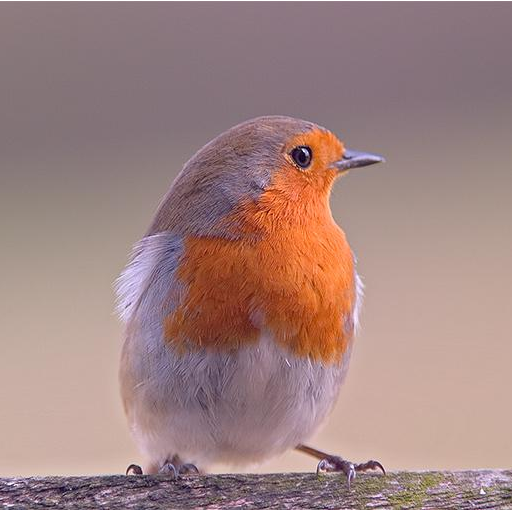

In [15]:
# Descarga de imagen de prueba (misma lógica que el notebook 'download_default_image.ipynb')
from IPython.display import Image, display
import urllib.request
import subprocess

default_image = "http://www.hpca.ual.es/~vruiz/images/pajarillo_512x512.png"

print(f"Descargando {default_image}...")
urllib.request.urlretrieve(default_image, "/tmp/original.png")
subprocess.run(["cp", "/tmp/original.png", "/tmp/test_image.png"], check=True)

print("✅ Descarga completada")
display(Image(filename="/tmp/original.png"))


In [16]:
from PIL import Image as PILImage
import numpy as np, os

BASE_DIR = "/tmp/NLM"
FRAMES_DIR = os.path.join(BASE_DIR, "frames")

img = PILImage.open("/tmp/original.png").convert("RGB")
arr = np.array(img)

N_FRAMES = 30
for i in range(N_FRAMES):
    PILImage.fromarray(arr).save(os.path.join(FRAMES_DIR, f"frame_{i:03d}.png"))

print("✅ Frames generados:", len(os.listdir(FRAMES_DIR)))


✅ Frames generados: 30


In [17]:
# c) Uso dentro de VCF (estilo: encode/decode/test/compare)
# Nota: usamos --multi para la variante temporal (ColoredMulti)

!python ../src/NLM.py compare
!python ../src/NLM.py encode --frame 20 --sigma 25
!python ../src/NLM.py decode --frame 20 --multi --temporal 5 --h 10 --hColor 10 --template 7 --search 21
!python ../src/NLM.py test --frame 20


FRAMES_DIR : /tmp/NLM/frames
COMP_DIR   : /tmp/NLM/compressed
RESULTS_DIR: /tmp/NLM/results
[encode] original : /tmp/NLM/frames/frame_020.png
[encode] noisy    : /tmp/NLM/compressed/frame_020_noisy.png
[encode] meta     : /tmp/NLM/compressed/frame_020_meta.npz
[decode] noisy    : /tmp/NLM/compressed/frame_020_noisy.png
[decode] denoised : /tmp/NLM/results/frame_020_nlm_multi.png
[test] PSNR(original, noisy)    = 20.24 dB
[test] PSNR(original, denoised) = 30.94 dB


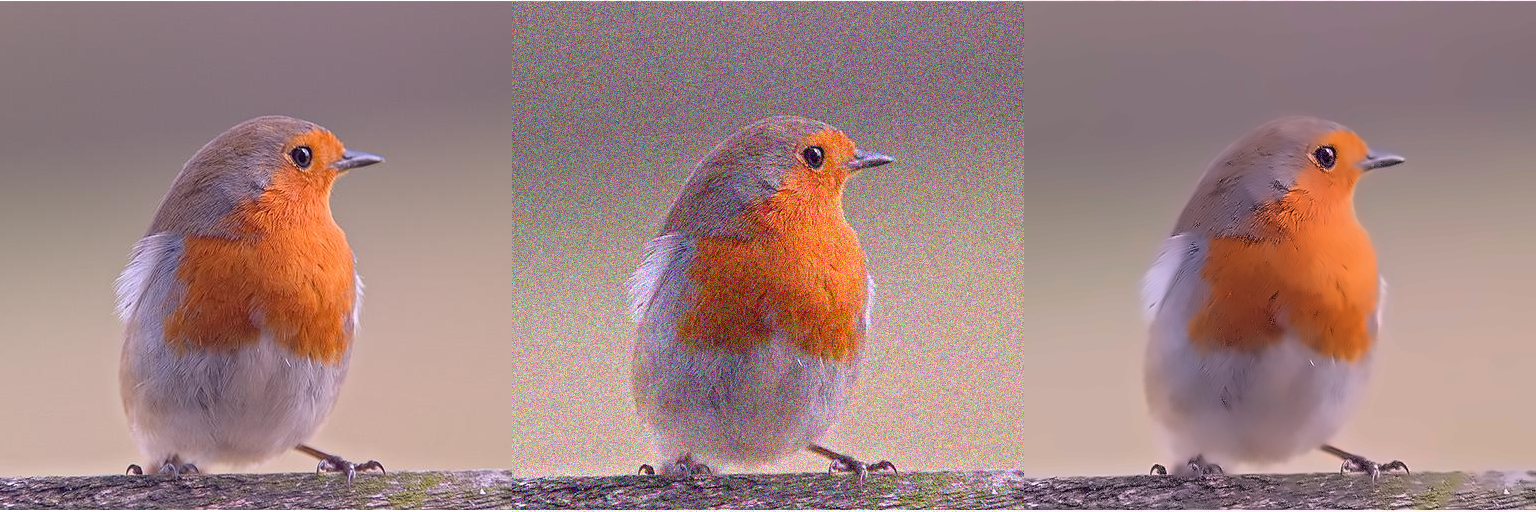

Mostrando: Original | Noisy | Denoised
Denoised: /tmp/NLM/results/frame_020_nlm_multi.png


In [18]:
from IPython.display import display
from PIL import Image as PILImage
import numpy as np, os

BASE_DIR = "/tmp/NLM"
FRAMES_DIR = os.path.join(BASE_DIR, "frames")
COMP_DIR = os.path.join(BASE_DIR, "compressed")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

orig = np.array(PILImage.open(os.path.join(FRAMES_DIR, "frame_020.png")).convert("RGB"))
noisy = np.array(PILImage.open(os.path.join(COMP_DIR, "frame_020_noisy.png")).convert("RGB"))

den_path_multi = os.path.join(RESULTS_DIR, "frame_020_nlm_multi.png")
den_path_single = os.path.join(RESULTS_DIR, "frame_020_nlm_single.png")
den_path = den_path_multi if os.path.exists(den_path_multi) else den_path_single

den = np.array(PILImage.open(den_path).convert("RGB"))

concat = np.hstack([orig, noisy, den])
display(PILImage.fromarray(concat))
print("Mostrando: Original | Noisy | Denoised")
print("Denoised:", den_path)


## 4. Uso dentro de VCF

Este “codec” sigue el patrón típico usado en prácticas VCF:
- **/frames**: entrada (secuencia de imágenes).
- **/compressed**: salida del *encode* (aquí, el frame ruidoso + meta).
- **/results**: salida reconstruida/filtrada (*decode*).

Comandos:
- `python ../src/NLM.py encode --frame 20 --sigma 25`
- `python ../src/NLM.py decode --frame 20 --multi --temporal 5`
- `python ../src/NLM.py test --frame 20`
- `python ../src/NLM.py compare`

Ajusta **h**, **template** y **search** para observar el compromiso entre eliminación de ruido y pérdida de detalle.
